# Movie2Watch

## Collaborative Filtering Movie Recommendation System

Data is pulled from https://grouplens.org/datasets/movielens/

In [207]:
import gzip
import math
import random
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [22]:
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

# Reading the data

In [23]:
#looking at movies and ratings datasets

In [24]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [25]:
len(movies)

9742

In [26]:
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [27]:
len(ratings)

100836

# EDA

In [171]:
# distribution of ratings
ratings['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [178]:
item_pop = ratings['movieId'].value_counts()

In [241]:
item_pop[:5]

356     329
318     317
296     307
593     279
2571    278
Name: movieId, dtype: int64

In [177]:
eda = ratings['movieId'].to_frame()
eda['ratings'] = ratings['rating']

In [184]:
means = eda.groupby(['movieId']).mean()
means['counts'] = item_pop.to_frame().sort_index()['movieId']
means = means.sort_values('counts', ascending = False)

In [240]:
means[:5]

ratings  counts
movieId                  
356      4.164134     329
318      4.429022     317
296      4.197068     307
593      4.161290     279
2571     4.192446     278

### Relationship between movie popularity and average ratings

<AxesSubplot:xlabel='counts', ylabel='ratings'>

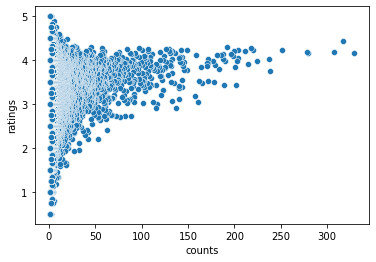

In [189]:
sns.scatterplot('counts', 'ratings', data = means)

Judging by the graph, we can see that the movies with more reviews have an average rating of around 4.0.

# Cleaning/Removing Noise from the data
To make our dataset more credible, we do not want movies that were rated by a small number of users and we also do not want users who rated very little movies. 

Our filters will be:

- the user must have reviewed a minimum of 30 movies.
- the movie must have a minimum of 20 user reviews.


In [226]:
movie_counts = ratings.groupby('movieId')['movieId'].agg('count')
user_counts = ratings.groupby('userId')['userId'].agg('count')

### Removing users that have less than 30 movie reviews

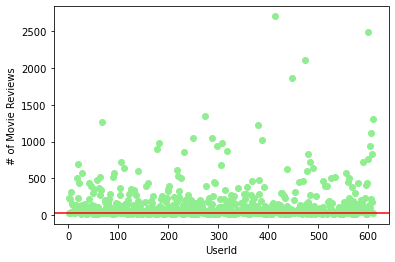

In [231]:
plt.scatter(user_counts.index, user_counts,color='lightgreen')
plt.axhline(y=30, color='red')
plt.xlabel('UserId')
plt.ylabel('# of Movie Reviews')
plt.show()

In [29]:
# get all where count of users > 30

In [30]:
qualified_users = ratings[ratings.groupby('userId')['userId'].transform('size') > 30]

In [31]:
len(qualified_users)

98141

### Removing movies that have less than 20 user reviews

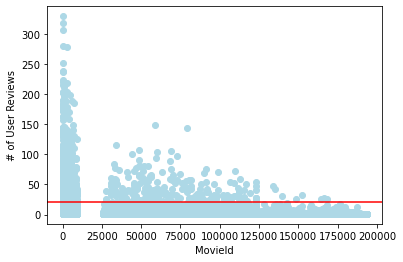

In [228]:
plt.scatter(movie_counts.index, movie_counts,color='lightblue')
plt.axhline(y=20, color='red')
plt.xlabel('MovieId')
plt.ylabel('# of User Reviews')
plt.show()

In [32]:
# get all where count of movies > 20

In [33]:
qualified_movies = ratings[ratings.groupby('movieId')['movieId'].transform('size') > 20]

In [34]:
len(qualified_movies)

66658

### Combining both filters

In [1]:
# get all of where count of movies > 20 and count of users > 30

In [36]:
qualified_ratings = pd.merge(qualified_users, qualified_movies, how = 'inner')

In [38]:
qualified_ratings

userId  movieId  rating   timestamp
0           1        1     4.0   964982703
1           1        3     4.0   964981247
2           1        6     4.0   964982224
3           1       47     5.0   964983815
4           1       50     5.0   964982931
...       ...      ...     ...         ...
64406     610   148626     4.0  1493847175
64407     610   152081     4.0  1493846503
64408     610   164179     5.0  1493845631
64409     610   166528     4.0  1493879365
64410     610   168252     5.0  1493846352

[64411 rows x 4 columns]

### Combining movieid with title

In [90]:
final_data = pd.merge(qualified_ratings, movies, how = 'inner', on = 'movieId')

In [91]:
final_data

userId  movieId  rating   timestamp                           title  \
0           1        1     4.0   964982703                Toy Story (1995)   
1           5        1     4.0   847434962                Toy Story (1995)   
2           7        1     4.5  1106635946                Toy Story (1995)   
3          15        1     2.5  1510577970                Toy Story (1995)   
4          17        1     4.5  1305696483                Toy Story (1995)   
...       ...      ...     ...         ...                             ...   
64406     572     2013     1.0   945887535  Poseidon Adventure, The (1972)   
64407     577     2013     3.0   945967440  Poseidon Adventure, The (1972)   
64408     590     2013     2.5  1258420216  Poseidon Adventure, The (1972)   
64409     597     2013     3.0   941640433  Poseidon Adventure, The (1972)   
64410     600     2013     3.5  1237715986  Poseidon Adventure, The (1972)   

                                            genres  
0      Adventure|Animation|Children|Comedy|Fantasy  
1      Adventure|Animation|Children|Comedy|Fantasy  
2      Adventure|Animation|Children|Comedy|Fantasy  
3      Adventure|Animation|Children|Comedy|Fantasy  
4      Adventure|Animation|Children|Comedy|Fantasy  
...                                            ...  
64406                       Action|Adventure|Drama  
64407                       Action|Adventure|Drama  
64408                       Action|Adventure|Drama  
64409                       Action|Adventure|Drama  
64410                       Action|Adventure|Drama  

[64411 rows x 6 columns]

In [137]:
# check if there are no duplicate titles
len(final_data['title'].unique()) == len(final_data['movieId'].unique())

True

In [92]:
#json format
d = final_data.to_json(orient='records')
data = json.loads(d)

In [93]:
data[:1]

[{'userId': 1,
  'movieId': 1,
  'rating': 4.0,
  'timestamp': 964982703,
  'title': 'Toy Story (1995)',
  'genres': 'Adventure|Animation|Children|Comedy|Fantasy'}]

### Plan: item-based collaborative filtering algorithm

In [244]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/548/1*pv6CDVqPgITYi_Nr0RygUw.png")
# image found at https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109
# image by Ramya Vidiyala, author of above article

In [150]:
# utility data structures
usersPerMovie = defaultdict(set) # Maps a movie to the users who rated it
MoviesPerUser = defaultdict(set) # Maps a user to the movies that they rated
ratingD = {} # Rating for user/movie pairs

In [151]:
for d in data:
    user, movie = d['userId'], d['title']
    usersPerMovie[movie].add(user)
    MoviesPerUser[user].add(movie)
    ratingD[(user,movie)] = d['rating']

In [236]:
def Cosine(i1, i2):
    # Between two movies
    inter = usersPerMovie[i1].intersection(usersPerMovie[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingD[(u,i1)]*ratingD[(u,i2)]
    for u in usersPerMovie[i1]:
        denom1 += ratingD[(u,i1)]**2
    for u in usersPerMovie[i2]:
        denom2 += ratingD[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [235]:
def similar_movie(i, N): # i = movieName in the format 'movieName (yearReleased)', N = number of similar movies
    similarities = []
    users = usersPerMovie[i]
    for i2 in usersPerMovie:
        if i2 == i: continue
        sim = Cosine(i, i2)
        similarities.append((sim,i2))
    similarities.sort(reverse=True)
    return similarities[:N]

#### Query has to be in the format 'movieName (year released)'

In [237]:
test = similar_movie('Jurassic Park (1993)', 10)

In [246]:
# Output is ('Similarity', 'MovieName')
test

[(0.7348170399903055, 'Terminator 2: Judgment Day (1991)'),
 (0.7034848018692534, 'Forrest Gump (1994)'),
 (0.6820273058705059, 'Braveheart (1995)'),
 (0.6779277579588566, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.6740188457425691, 'Fugitive, The (1993)'),
 (0.6698532199931299, 'Speed (1994)'),
 (0.6560318133077641, 'Batman (1989)'),
 (0.6404456026822191, 'True Lies (1994)'),
 (0.6361478139259309, 'Apollo 13 (1995)'),
 (0.6331401842538178, 'Lion King, The (1994)')]

As shown in this test output, our model is working correctly predicting recommendations based on user behavior/reviews. We can also see this in action as the system is recommending movies that are released near the same year as the movie query.